In [1]:
!nvidia-smi

Mon Sep 16 11:55:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    21W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Load Libraries and Import Data

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from datetime import datetime
import warnings
warnings.simplefilter("ignore")

from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
data = pd.read_csv('./casualty_train.csv')
data.head()

,casualty_class,gender,age,severe,pedestrian_location,pedestrian_movement,travel,year
0,passenger,female,33,False,NaN,NaN,motorbike,2007
1,passenger,female,20,False,NaN,NaN,car,2005
2,passenger,male,52,False,NaN,NaN,car,2006
3,passenger,female,17,False,NaN,NaN,pedestrian,2012
4,passenger,female,20,False,NaN,NaN,motorbike,2010


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232835 entries, 0 to 232834
Data columns (total 8 columns):
casualty_class         232835 non-null object
gender                 232835 non-null object
age                    232835 non-null object
severe                 232835 non-null bool
pedestrian_location    43259 non-null object
pedestrian_movement    43259 non-null object
travel                 232835 non-null object
year                   232835 non-null int64
dtypes: bool(1), int64(1), object(6)
memory usage: 12.7+ MB


## Check for Class Imbalance

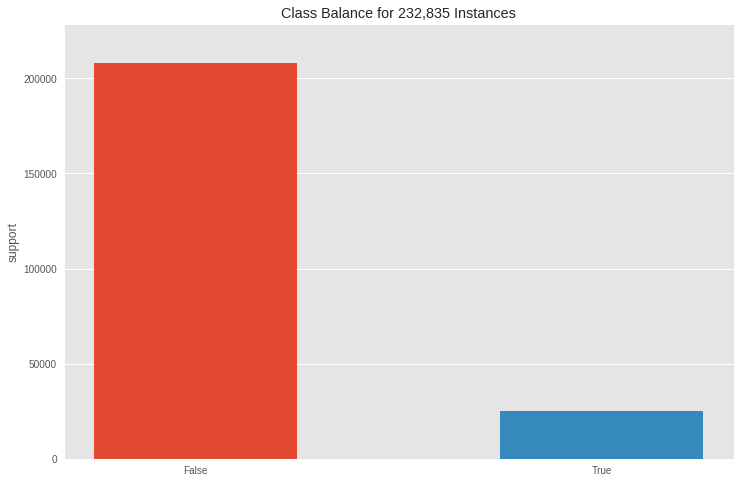

In [5]:
y = data.severe.values
plt.rcParams['figure.figsize'] = (12, 8)
visualizer = ClassBalance(labels=["False", "True"])
visualizer.fit(y)
visualizer.poof()
#we will need to perform stratified sampling during train/test split, under the assumption
#that the imbalance is present during evaluation too

In [6]:
print(data.casualty_class.unique())
print(data.travel.unique())
print(data.pedestrian_location.unique())
print(data.pedestrian_movement.unique())
print(data.year.unique())

['passenger' 'pedestrian' 'driver']
['motorbike' 'car' 'pedestrian' 'bicycle' 'taxi' 'bus' 'other']
[nan 'In road' 'Close to Crossing' 'Not on Crossing' 'Unknown'
 'Pedestrian Crossing' 'Footpath' 'Zig-Zag']
[nan 'In Rd Not Crossing' 'Drivers N/Side' 'Unknown Or Other'
 'Drivers N/Side Msk' 'Drivers O/Side' 'Back To Traffic'
 'Drivers O/Side Msk' 'Facing Traffic' 'In Rd Not Crossing Msk']
[2007 2005 2006 2012 2010 2008 2011 2009 2014 2013]


## Data Preprocessing

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

data.age = OrdinalEncoder().fit_transform(np.array(data.age).reshape(-1,1))
data = pd.get_dummies(data, columns=['casualty_class', 'gender', 'year', 'pedestrian_location',
                                     'pedestrian_movement', 'travel'])
data.severe = LabelEncoder().fit_transform(data.severe)

data.head()

,age,severe,casualty_class_driver,casualty_class_passenger,casualty_class_pedestrian,gender_female,gender_male,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,pedestrian_location_Close to Crossing,pedestrian_location_Footpath,pedestrian_location_In road,pedestrian_location_Not on Crossing,pedestrian_location_Pedestrian Crossing,pedestrian_location_Unknown,pedestrian_location_Zig-Zag,pedestrian_movement_Back To Traffic,pedestrian_movement_Drivers N/Side,pedestrian_movement_Drivers N/Side Msk,pedestrian_movement_Drivers O/Side,pedestrian_movement_Drivers O/Side Msk,pedestrian_movement_Facing Traffic,pedestrian_movement_In Rd Not Crossing,pedestrian_movement_In Rd Not Crossing Msk,pedestrian_movement_Unknown Or Other,travel_bicycle,travel_bus,travel_car,travel_motorbike,travel_other,travel_pedestrian,travel_taxi
0,27.0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,13.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,48.0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,9.0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,13.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Create Train/Test Sets

In [8]:
from sklearn.model_selection import train_test_split

y = data.severe
X = data.loc[:, data.columns != 'severe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((186268, 39), (46567, 39), (186268,), (46567,))

In [9]:
import xgboost as xgb

clf = xgb.XGBClassifier(learning_rate=0.1,
                        n_estimators=200,
                        min_child_weight=8,
                        scale_pos_weight=1,
                        objective= 'binary:logistic',
                        seed=27,
                        tree_method='gpu_hist',
                        metric='error')
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3, metric='error',
              min_child_weight=8, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [10]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

Test Accuracy:  0.891296411621964


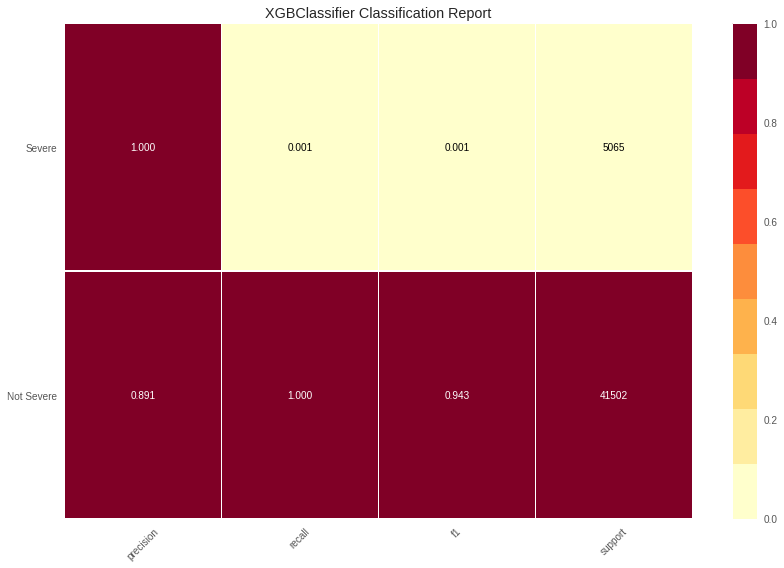

In [11]:
visualizer = ClassificationReport(clf, classes=["Not Severe", "Severe"], support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()    

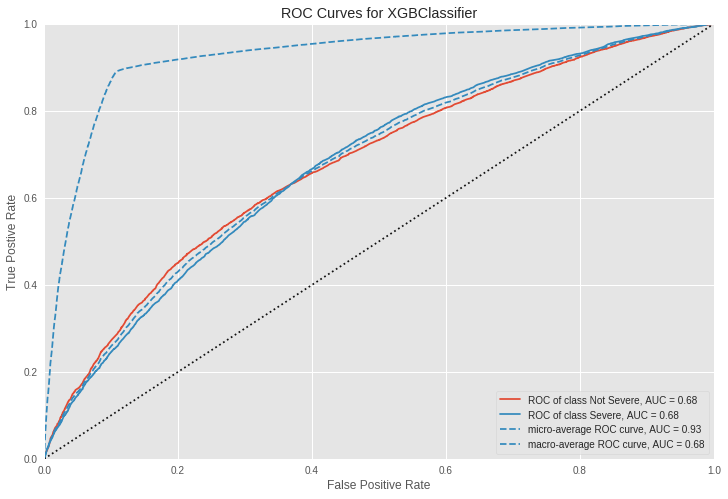

In [12]:
visualizer = ROCAUC(clf, classes=["Not Severe", "Severe"])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.poof()                      

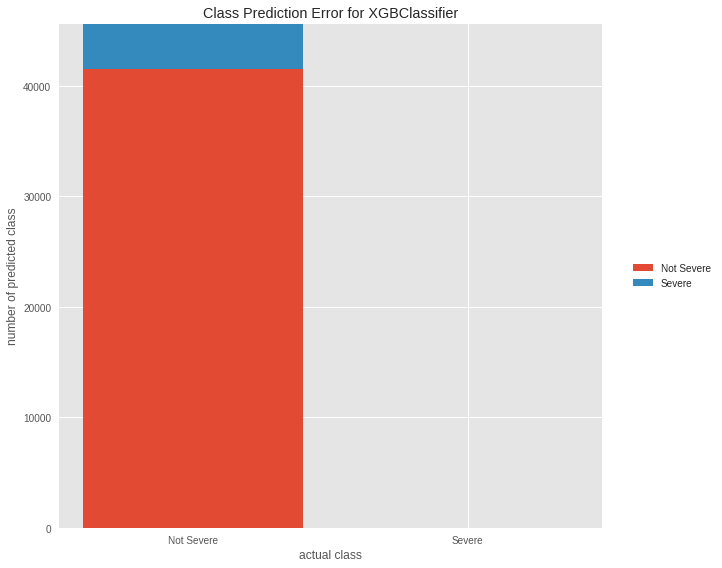

In [13]:
visualizer = ClassPredictionError(clf, classes=["Not Severe", "Severe"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

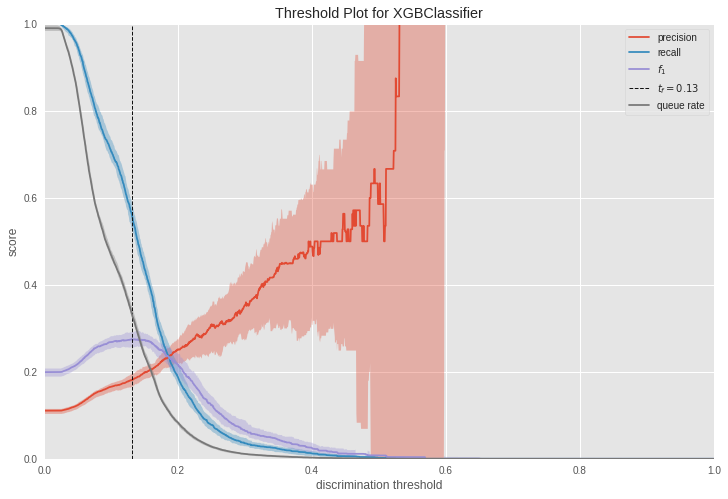

In [14]:
visualizer = DiscriminationThreshold(clf)

visualizer.fit(X_test, y_test)
visualizer.poof()  